# Fibonacci Retracement Strategy

### Load the data

In [40]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

In [41]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [42]:
df = dataset.copy()

In [43]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2024-10-25 09:20:00,1338.4,1338.6,1337.4,1337.7,4128
2024-10-25 09:25:00,1337.7,1338.0,1337.0,1337.7,2796
2024-10-25 09:30:00,1337.7,1338.0,1335.5,1336.2,4931


In [44]:
df.columns = ["open", "high", "low", "close", "volume"]

In [45]:
df = df.resample('H').agg({
        'open': 'first',
        'close': 'last',
        'high': 'max',
        'low': 'min',
        'volume': 'sum'
    })
df.dropna(subset=['close'], inplace=True)

In [46]:
#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df['RSI'] = ta.rsi(df.close, length=12)
df['EMA'] = ta.ema(df.close, length=150)
df.tail()

df=df[0:2000]

### Trend detection

In [47]:
EMAsignal = [0]*len(df)
backcandles = 15

for row in range(backcandles, len(df)):
    upt = 1
    dnt = 1
    for i in range(row-backcandles, row+1):
        if max(df.open[i], df.close[i])>=df.EMA[i]:
            dnt=0
        if min(df.open[i], df.close[i])<=df.EMA[i]:
            upt=0
    if upt==1 and dnt==1:
        EMAsignal[row]=3
    elif upt==1:
        EMAsignal[row]=2
    elif dnt==1:
        EMAsignal[row]=1

df['EMASignal'] = EMAsignal

In [48]:
def generate_signal(df,l,backcandles, gap, zone_threshold, price_diff_threshold):
    max_price = df.high[l-backcandles:l-gap].max()
    min_price = df.low[l-backcandles:l-gap].min()
    index_max = df.high[l-backcandles:l-gap].idxmax()
    index_min = df.low[l-backcandles:l-gap].idxmin()
    price_diff = max_price - min_price

    if (df.EMASignal[l] == 2
        and (index_min < index_max)
        and price_diff>price_diff_threshold):
        l1 = max_price - 0.62 * price_diff # position entry 0.62
        l2 = max_price - 0.78 * price_diff # SL 0.78
        l3 = max_price - 0. * price_diff # TP
        if abs(df.close[l]-l1) < zone_threshold and df.high[l-gap:l].min()>l1:
            return (2, l2, l3, index_min, index_max)
        else:
            return (0,0,0,0,0)

    elif (df.EMASignal[l] == 1
          and (index_min > index_max)
          and price_diff>price_diff_threshold):
        l1 = min_price + 0.62 * price_diff # position entry 0.62
        l2 = min_price + 0.78 * price_diff # SL 0.78
        l3 = min_price + 0. * price_diff # TP
        if abs(df.close[l]-l1) < zone_threshold and df.low[l-gap:l].max()<l1:
            return (1, l2, l3, index_min, index_max)
        else:
            return (0,0,0,0,0)

    else:
        return (0,0,0,0,0)


gap_candles = 5
backcandles = 40
signal = [0 for i in range(len(df))]
TP = [0 for i in range(len(df))]
SL = [0 for i in range(len(df))]
MinSwing = [0 for i in range(len(df))]
MaxSwing = [0 for i in range(len(df))]

for row in range(backcandles, len(df)):
    gen_sig = generate_signal(df, row, backcandles=backcandles, gap=gap_candles, zone_threshold=0.001, price_diff_threshold=0.01)
    signal[row] = gen_sig[0]
    SL[row] = gen_sig[1]
    TP[row] = gen_sig[2]
    MinSwing[row] = gen_sig[3]
    MaxSwing[row] = gen_sig[4]

df['signal'] = signal
df['SL'] = SL
df['TP'] = TP
df['MinSwing'] = MinSwing
df['MaxSwing'] = MaxSwing


In [49]:
df[df.signal !=0][:10]
#df.head(50)

,open,close,high,low,volume,RSI,EMA,EMASignal,signal,SL,TP,MinSwing,MaxSwing


In [50]:
import numpy as np
def pointpos(x):
    if x['signal']==1:
        return x['high']+1e-4
    elif x['signal']==2:
        return x['low']-1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

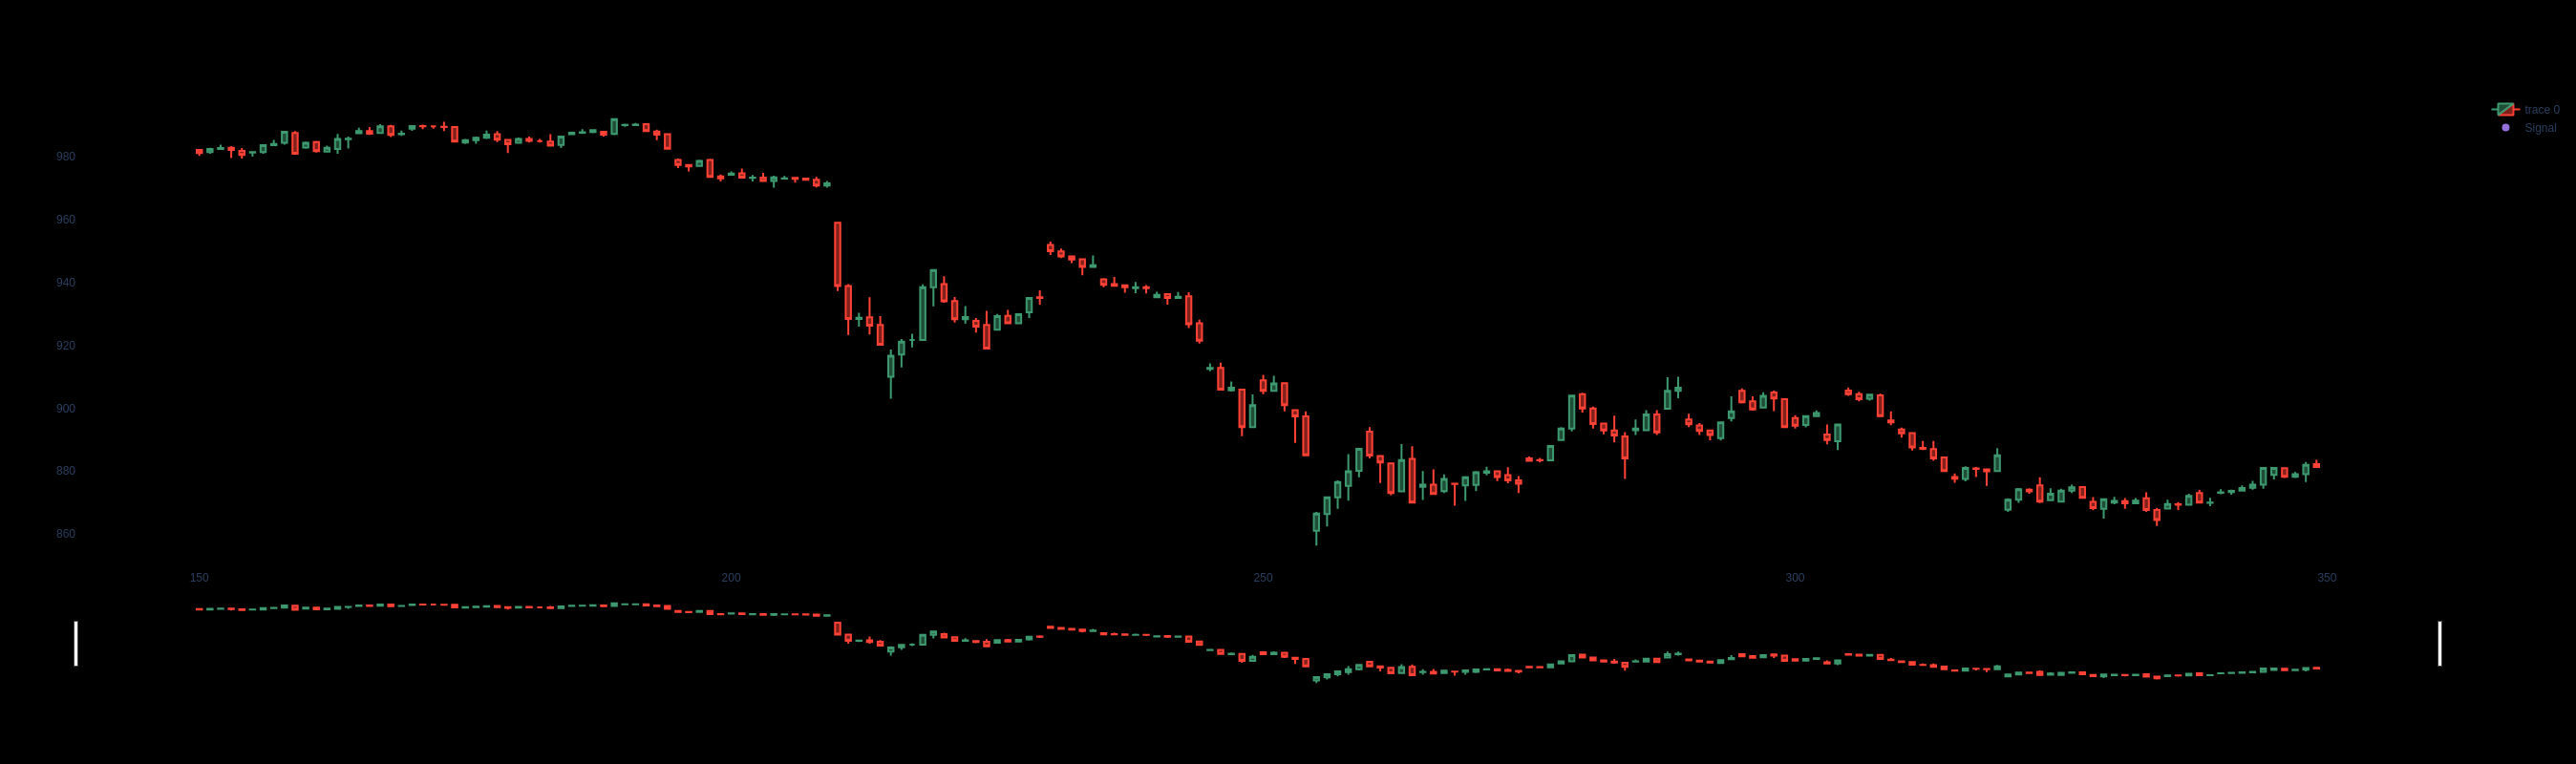

In [51]:
dfpl = df[150:350]
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    paper_bgcolor='black',
    plot_bgcolor='black')
fig.update_xaxes(gridcolor='black')
fig.update_yaxes(gridcolor='black')
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="Signal")
fig.show()

In [52]:
df = df.rename(columns={"open": "Open", "high":"High", "low":"Low", "close": "Close", "volume":"Volume"})
def SIGNAL():
    return df.signal

In [53]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    mysize = 0.99 #1000
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.SL[-1]
            tp1 = self.data.TP[-1]
            tp2 = tp1-(tp1-self.data.Close[-1])/2
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
            self.buy(sl=sl1, tp=tp2, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.SL[-1]
            tp1 = self.data.TP[-1]
            tp2 = tp1+(self.data.Close[-1]-tp1)/2
            self.sell(sl=sl1, tp=tp1, size=self.mysize)
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(df, MyStrat, cash=100, margin=1/100, commission=0.0000)
stat = bt.run()
stat

Start                                     0.0
End                                    1999.0
Duration                               1999.0
Exposure Time [%]                         0.0
Equity Final [$]                        100.0
Equity Peak [$]                         100.0
Return [%]                                0.0
Buy & Hold Return [%]              -33.171247
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  0.0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [54]:
bt.plot()

GridPlot(id='p1586', ...)